In [1]:
import cv2
import numpy as np
from skimage import filters, measure, segmentation, feature, color
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi ,  voronoi_plot_2d


In [2]:
def show_image(title, img, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


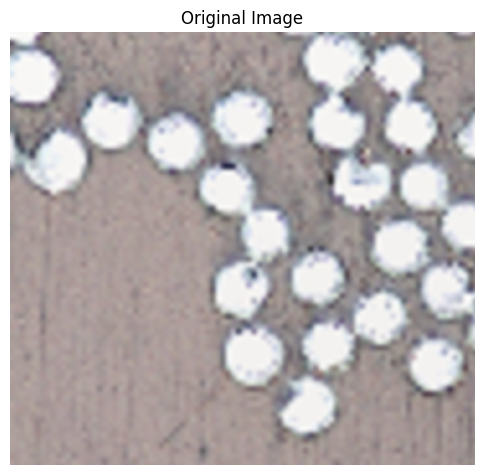

In [3]:
image = cv2.imread('image3.png')
original = image.copy()


show_image("Original Image", image, cmap=None)

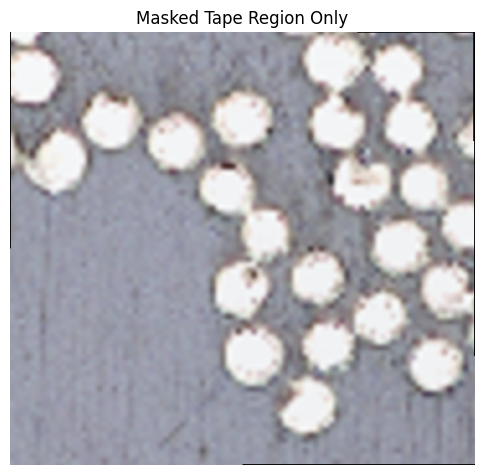

In [4]:
# Polygon drawing (manual clicks with OpenCV window)
drawing = False
points = []

def click_event(event, x, y, flags, param):
    global points
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(temp_img, (x, y), 3, (0, 255, 255), -1)
        if len(points) > 1:
            cv2.line(temp_img, points[-2], points[-1], (0, 255, 255), 2)
        cv2.imshow('Draw Tape Boundary - Press q when done', temp_img)

# Create a copy of the original image for drawing
temp_img = original.copy()
cv2.imshow('Draw Tape Boundary - Press q when done', temp_img)
cv2.setMouseCallback('Draw Tape Boundary - Press q when done', click_event)

# Wait for user to finish drawing
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

# Create a binary mask from the drawn polygon
mask = np.zeros(image.shape[:2], dtype=np.uint8)
pts = np.array(points, np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(mask, [pts], 255)

# Apply mask to the original image
image = cv2.bitwise_and(original, original, mask=mask)

# Optional: Display the result
show_image("Masked Tape Region Only", cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap=None)


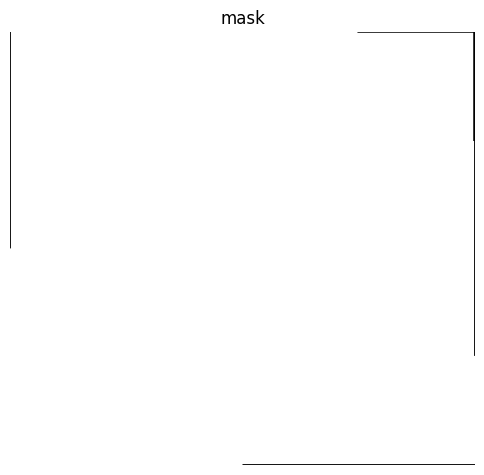

In [5]:
show_image("mask", mask)

---- Mean Shift Filtering ----

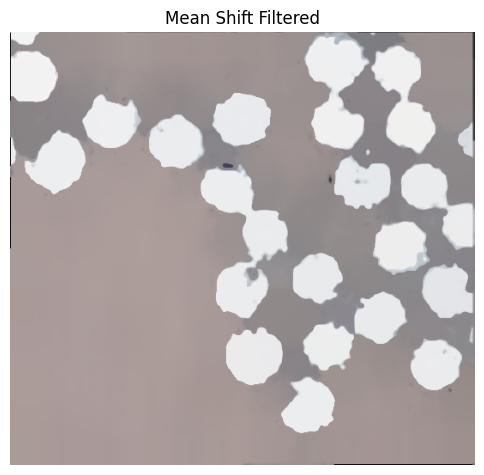

In [6]:
mean_shifted = cv2.pyrMeanShiftFiltering(image, sp=30, sr=50)
show_image("Mean Shift Filtered", mean_shifted, cmap=None)

---- Blur effect (mean (uniform) blur) equal weighted square matrix kernel ----

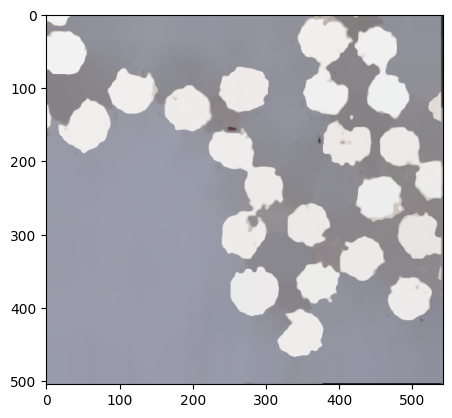

In [7]:
mean_shifted_rgb = cv2.cvtColor(mean_shifted, cv2.COLOR_BGR2RGB)
plt.imshow(mean_shifted_rgb)


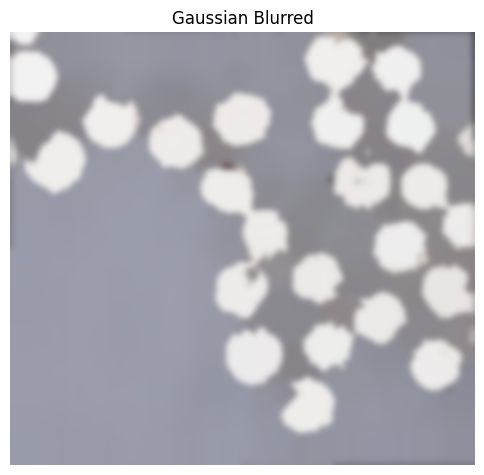

In [35]:

blurred = cv2.GaussianBlur(mean_shifted_rgb, (21,21), 0)
show_image("Gaussian Blurred", blurred, cmap=None)

---- Gray scaling ----

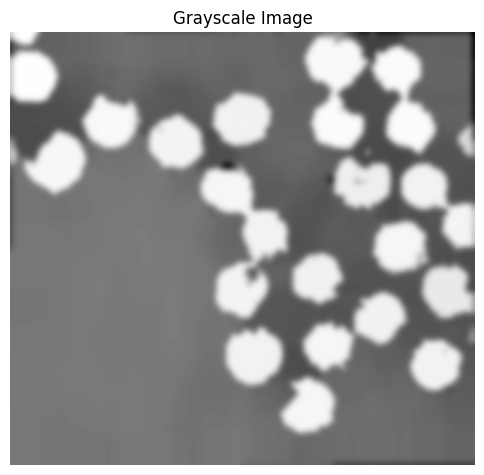

In [36]:
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
show_image("Grayscale Image", gray)

---- Thresholding ----

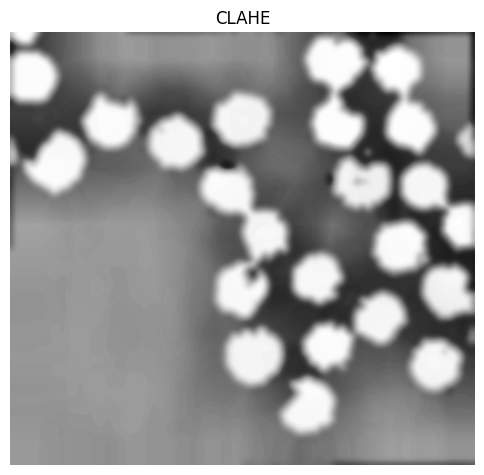

In [42]:
# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_clahe = clahe.apply(gray)
show_image("CLAHE", gray_clahe)

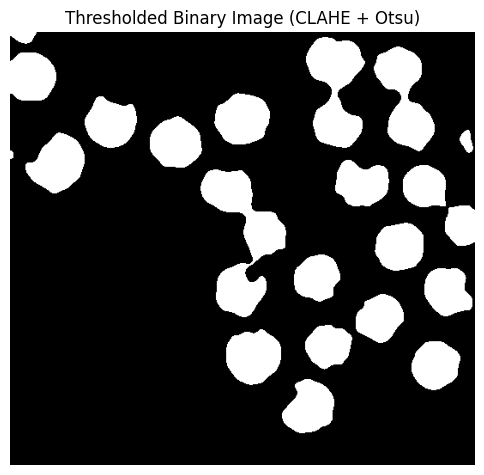

In [41]:

blurred = cv2.GaussianBlur(gray_clahe,(5,5),0)
# Apply Otsu's Thresholding
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show_image("Thresholded Binary Image (CLAHE + Otsu)", binary)

#before applying the clahe and gussian blur, the threshold was so bad otsu said that the optimal is 84 which wasn't actually the optimal in our sitation. so we did clahe and gussian with otsu and it said optimal is 90 which is correct
#because there are darker regions in middle and bottom it was hard for otsu alone to detect it

---- Euclidean Distance Map ----

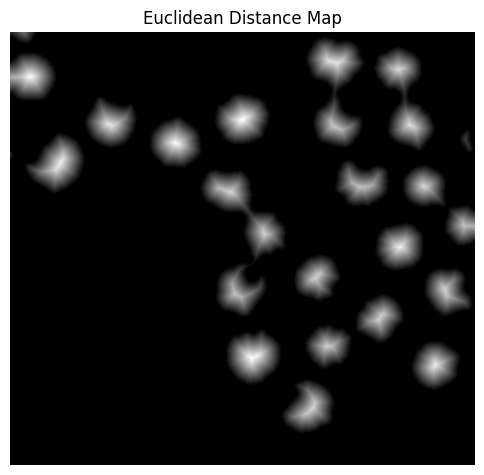

In [11]:
distance_map = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
show_image("Euclidean Distance Map", distance_map)

---- Local Maxima Search ----

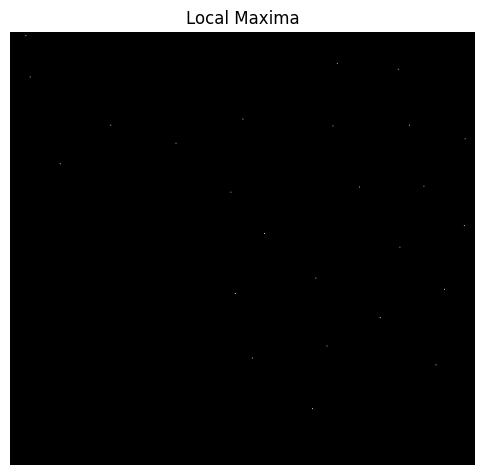

In [12]:
# Updated version without 'indices'
coordinates = feature.peak_local_max(
    distance_map, min_distance=5, labels=binary
)

# Create a binary mask from the coordinates
local_max = np.zeros_like(distance_map, dtype=bool)
local_max[tuple(coordinates.T)] = True

show_image("Local Maxima", local_max)

---- Connected Components ----

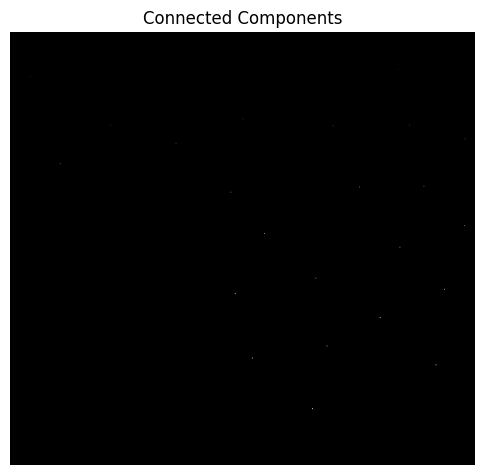

In [13]:
markers, _ = ndimage.label(local_max)
show_image("Connected Components", markers)

---- Watershed algorithm ----

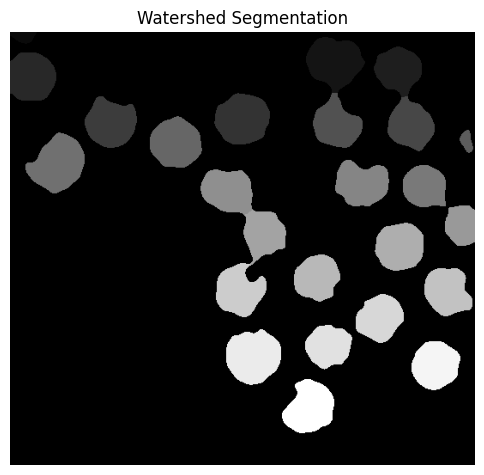

In [14]:
labels = segmentation.watershed(-distance_map, markers, mask=binary)
show_image("Watershed Segmentation", labels)

---- fiber center and contour extraction ----

In [15]:
contours = []


# Loop over each label (ignoring background label 0)
for label_id in np.unique(labels):
    if label_id == 0:
        continue
 # Create a binary mask for the current label
    mask_label = np.uint8(labels == label_id)

    # Find contours for the current label
    cnts, _ = cv2.findContours(mask_label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        contours.append(cnts[0])  # Assuming one contour per object



props = measure.regionprops(labels)
fibre_centers = [prop.centroid for prop in props]
print(f"Initial detected centers: {len(fibre_centers)}")
print(f"Initial detected co: {len(contours)}")


Initial detected centers: 25
Initial detected co: 25


---- Proximity - neighbour check ----

In [16]:

def remove_close_points(points, contour, threshold=5):
    filtered = []
    contoured = []
    i=0
    for p in points:
        if all(np.linalg.norm(np.array(p) - np.array(f)) > threshold for f in filtered):
            contoured.append(contour[i])
            filtered.append(p)
            if i < len(contour):
                i+=1
    return filtered, contoured

filtered_centers, contours = remove_close_points(fibre_centers, contours)

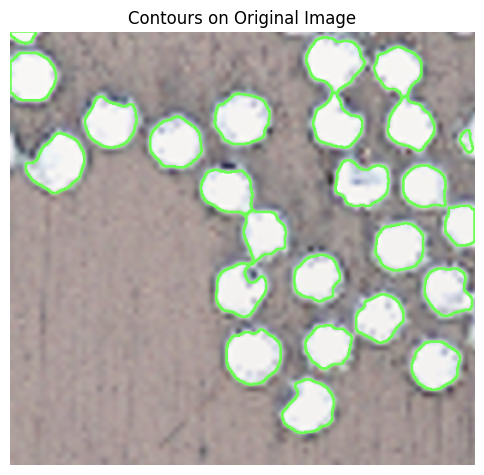

In [17]:
image_with_contours = original.copy()

# Draw the contours
cv2.drawContours(image_with_contours, contours, -1, (107, 255, 83), 2)  # Green color, thickness = 2

# Show the result
show_image("Contours on Original Image", image_with_contours, cmap=None)

---- Fibre coordinate array ----

In [18]:
print("Number of detected fibres:", len(filtered_centers))
for i, center in enumerate(filtered_centers):
    print(f"Fibre {i+1}: (y={center[0]:.2f}, x={center[1]:.2f})")

Number of detected fibres: 25
Fibre 1: (y=5.51, x=15.23)
Fibre 2: (y=35.71, x=377.79)
Fibre 3: (y=44.72, x=452.36)
Fibre 4: (y=52.93, x=24.82)
Fibre 5: (y=102.12, x=270.47)
Fibre 6: (y=106.63, x=116.96)
Fibre 7: (y=108.99, x=466.70)
Fibre 8: (y=108.24, x=380.14)
Fibre 9: (y=127.86, x=531.95)
Fibre 10: (y=129.97, x=192.80)
Fibre 11: (y=154.26, x=55.24)
Fibre 12: (y=180.83, x=483.16)
Fibre 13: (y=177.37, x=409.50)
Fibre 14: (y=185.71, x=253.69)
Fibre 15: (y=225.46, x=525.32)
Fibre 16: (y=235.54, x=295.41)
Fibre 17: (y=250.50, x=453.96)
Fibre 18: (y=286.58, x=357.33)
Fibre 19: (y=302.66, x=509.48)
Fibre 20: (y=302.01, x=266.81)
Fibre 21: (y=333.60, x=430.55)
Fibre 22: (y=366.23, x=370.73)
Fibre 23: (y=378.41, x=283.13)
Fibre 24: (y=388.40, x=495.52)
Fibre 25: (y=437.79, x=348.70)


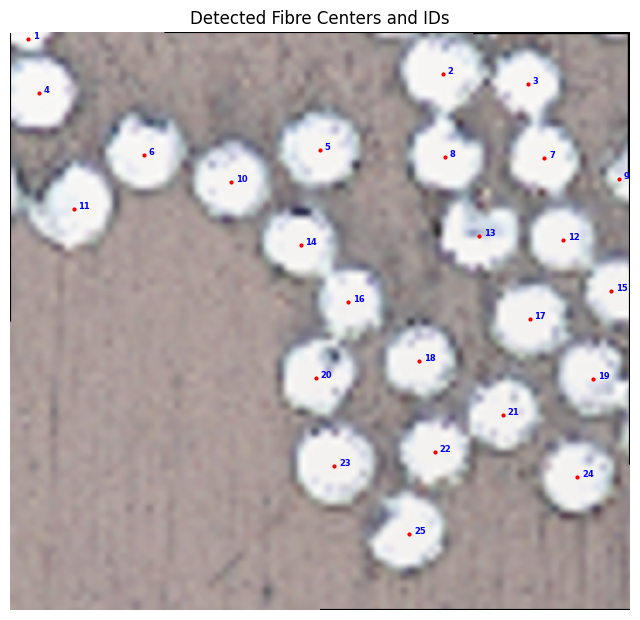

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)

# Plot red center and add label
for idx, (y, x) in enumerate(filtered_centers):
    ax.plot(x, y, 'ro', markersize=2)
    ax.text(x + 4, y, str(idx+1), color='blue', fontsize=6, weight='bold')  # Label

ax.set_title("Detected Fibre Centers and IDs")
plt.axis("off")
plt.show()



In [20]:
print("length of first index of contour",len(contours[0]))
contours[0]

length of first index of contour 27


array([[[ 0,  0]],

       [[ 0,  5]],

       [[ 1,  5]],

       [[ 3,  7]],

       [[ 4,  7]],

       [[ 7, 10]],

       [[ 8, 10]],

       [[10, 12]],

       [[12, 12]],

       [[13, 13]],

       [[16, 13]],

       [[17, 14]],

       [[19, 14]],

       [[20, 13]],

       [[22, 13]],

       [[23, 12]],

       [[24, 12]],

       [[25, 11]],

       [[25, 10]],

       [[26,  9]],

       [[26,  8]],

       [[27,  7]],

       [[27,  6]],

       [[29,  4]],

       [[29,  3]],

       [[30,  2]],

       [[30,  0]]], dtype=int32)

In [21]:
filtered_centers[0]

(np.float64(5.508823529411765), np.float64(15.226470588235294))

In [22]:
def average_radius_from_contour(contour, center, num_directions=8, tolerance=1.0):
    
    
    
    angles = np.linspace(0, 2 * np.pi, num_directions, endpoint=False) #compute 8 directions around a circle
    yc, xc = center
    distances = [] #stores each ray length.
    ray_endpoints = []  #saves hit points on the contour.

    contour = contour.reshape(-1, 2)  



    #loop over each direction and dx, dy are components of unit vector in this direction
    for theta in angles:
        dx = np.cos(theta)
        dy = np.sin(theta)
        r = 0 #distance from center that is incremented to step out along ray




        #step pixel by pixel along the ray
        #calculate the (x, y) coordinates of the current step on the ray.
        while True:
            x = int(round(xc + dx * r))
            y = int(round(yc + dy * r))




            #If the ray goes outside the image, stop
            if (x < 0 or y < 0 or y >= image.shape[0] or x >= image.shape[1]):
                break
            
            
            
            
            #check for hit on contour
            #If the current pixel matches any point on the contour, it's a hit!
            #Compute the distance from center to this contour point.
            #Save the distance and the (x, y) hit point.
            #Then stop this ray and go to the next one.
            #pointPolygonTest checks how close a point is to a contour and returns 0 if the point is on the contour. But we can relax the condition and accept points near the contour using a tolerance.
            dist_to_contour = cv2.pointPolygonTest(contour, (x, y), True)
            if abs(dist_to_contour) <= tolerance: 
                distances.append(np.sqrt((x - xc)**2 + (y - yc)**2)) #yc and xc are centers while x and y are the contour
                ray_endpoints.append((x, y))  # store hit point
                break

            #Increase r to keep moving out along the ray until a hit is found.
            r += 1


    #only return the average radius if at least 4 hits were found (for reliability)
    if len(distances) >= 1:
        return np.mean(distances), ray_endpoints
    else:
        return None, []






In [23]:
accepted_centers = []
average_radius = []
all_rays = []  


for center, contour in zip(filtered_centers, contours):
    avg_r, rays = average_radius_from_contour(contour, center)
    if avg_r is not None:
        accepted_centers.append(center)
        average_radius.append(avg_r)
        all_rays.append((center, rays))  # store rays for visualization


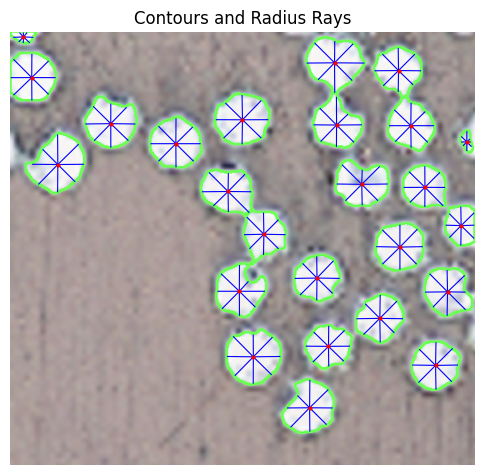

In [24]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image_with_contours)



# Draw rays from center to each sampled point
for center, rays in all_rays:
    yc, xc = center
    for (x, y) in rays:
        ax.plot([xc, x], [yc, y], color='blue', linewidth=0.8)

#draw center points
for y, x in accepted_centers:
    ax.plot(x, y, 'ro', markersize=2)

ax.set_title("Contours and Radius Rays")
plt.axis("off")
plt.show()



In [25]:
true_areas = [cv2.contourArea(np.array(cnt, dtype=np.int32)) for cnt in contours]

In [26]:
true_areas

[303.5,
 2925.5,
 2178.0,
 2484.5,
 2901.0,
 2573.5,
 2293.0,
 2281.0,
 243.0,
 2685.0,
 3082.0,
 1966.5,
 2467.5,
 2432.0,
 1351.0,
 2083.0,
 2470.0,
 2153.0,
 2308.5,
 2427.0,
 2211.5,
 2007.0,
 3098.5,
 2393.5,
 2654.5]

C:\Users\abdul\AppData\Local\Temp\ipykernel_26760\2228467164.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


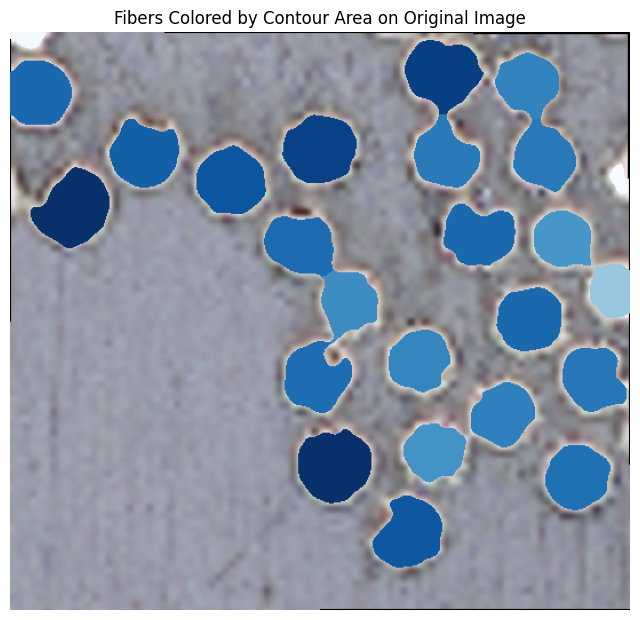

In [27]:

import matplotlib.cm as cm


#Normalize the true_areas to 0–1 for color mapping
areas = np.array(true_areas, dtype=np.float32)
norm_areas = (areas - areas.min()) / (areas.max() - areas.min()) 


cmap = cm.get_cmap('Blues')


image_overlay = image.copy()

#Loop through fibers and draw filled contour with blue intensity
for contour, norm_val in zip(contours, norm_areas):
    rgb = cmap(norm_val)[:3] 
    bgr = tuple(int(255 * c) for c in reversed(rgb))
    cv2.drawContours(image_overlay, [np.array(contour, dtype=np.int32)], -1, bgr, thickness=-1)

#Convert to RGB for matplotlib
overlay_rgb = cv2.cvtColor(image_overlay, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8, 8))
plt.imshow(overlay_rgb)
plt.title("Fibers Colored by Contour Area on Original Image")
plt.axis("off")
plt.show()

In [28]:
total_fiber_area = sum(true_areas)

#get total tape area
tape_area = cv2.countNonZero(mask)

V_fv = (total_fiber_area / tape_area) * 100
print(f"Fiber Volume Fraction (Vfv): {V_fv:.4f}")

Fiber Volume Fraction (Vfv): 20.5678


In [29]:
total_fiber_area = cv2.countNonZero(binary)


tape_area = image.shape[0] * image.shape[1]


V_fv = (total_fiber_area / tape_area) * 100
print(f"Fiber Volume Fraction (Vfv): {V_fv:.4f}")

Fiber Volume Fraction (Vfv): 21.1936


In [30]:
total_fiber_area = sum(true_areas)


tape_area = image.shape[0] * image.shape[1]


V_fv = (total_fiber_area / tape_area) * 100
print(f"Fiber Volume Fraction (Vfv): {V_fv:.4f}")

Fiber Volume Fraction (Vfv): 20.4499


In [31]:
total_fiber_area = cv2.countNonZero(binary)


tape_area = cv2.countNonZero(mask)


V_fv = (total_fiber_area / tape_area) * 100
print(f"Fiber Volume Fraction (Vfv): {V_fv:.4f}")

Fiber Volume Fraction (Vfv): 21.3158


In [32]:
import pandas as pd

fiber_ids = list(range(1, len(accepted_centers) + 1))
xs = [x for y, x in accepted_centers]
ys = [y for y, x in accepted_centers]

circular_areas = [np.pi * r**2 for r in average_radius]


df = pd.DataFrame({
    'Fiber_ID': fiber_ids,
    'X': [round(x, 6) for x in xs],
    'Y': [round(y, 6) for y in ys],
    'Average_Radius': [round(r, 6) for r in average_radius],
    'Circular_Area': [round(a, 1) for a in circular_areas],
    'Contour_Area': true_areas
})


df.to_csv('fiber_dataset_both_areas.csv', index=False)
print("Dataset saved as 'fiber_dataset_both_areas.csv'")

Dataset saved as 'fiber_dataset_both_areas.csv'
